In [231]:
import snapatac2 as snap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scanpy as sc
import polars as pl
import math
import scipy

import seaborn as sns
import os

from adjustText import adjust_text

In [2]:
snap.__version__

'2.8.0'

# Functions

In [3]:
from scipy import stats
from statsmodels.stats import multitest
def test_sig(x, y):
    if stats.shapiro(x).pvalue >= 0.05 and stats.shapiro(y).pvalue >= 0.05: #if they are normally distriuted
        print("t-test")
        return stats.ttest_ind(x,y)
    else:
        print("mann-whitney")
        return stats.mannwhitneyu(x, y)
def test_mannwhit(x, y):
    return stats.mannwhitneyu(x, y)
def test_ttest(x, y):
    return stats.ttest_ind(x, y)
def test_fdr(x):
     return multitest.fdrcorrection(x, alpha=0.05, method='indep', is_sorted=False)

In [4]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"    
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def convert_FDR_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "*****"
    elif pvalue <= 0.001:
        return "****"
    elif pvalue <= 0.01:
        return "***"
    elif pvalue <= 0.05:
        return "**"    
    elif pvalue <= 0.1:
        return "*"
    return "ns"

# Load Data

In [12]:
# Load data for peak-matrix (for subset of interest) - iterative peaks
data1 = snap.read('peak-matrix-iterative.h5ad')

In [13]:
data1 = data1[:,data1.var_names.str.startswith('chr')]
data1 = data1[:,~data1.var_names.str.startswith('chrM')]

In [14]:
data1 = data1[~(data1.obs['Vaccine'] == 'J&J') ,:]

In [15]:
data1.obs['new_isg_subset'] = data1.obs['new_isg_subset'].replace(
    'Monocyte CD14 ISG 1','ISG_High')
data1.obs['new_isg_subset'] = data1.obs['new_isg_subset'].replace(
    'Monocyte CD14 ISG 2','ISG_High')
data1.obs['new_isg_subset'] = data1.obs['new_isg_subset'].replace(
    'Monocyte CD14 ISG (Low)','ISG_Dim')
data1.obs['new_isg_subset'] = data1.obs['new_isg_subset'].replace(
    'Monocyte CD14','ISG_None')
data1.obs['new_isg_subset'] = data1.obs['new_isg_subset'].str.replace(' ','_')

/tmp/ipykernel_1225379/152126601.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data1.obs['new_isg_subset'] = data1.obs['new_isg_subset'].replace(


In [17]:
data1.obs['isg_sub_donor'] = data1.obs['new_isg_subset'].astype(str) + '_' + data1.obs['person'].astype(str)
data1.obs['isg_sub_vac'] = data1.obs['new_isg_subset'].astype(str) + '_' +data1.obs['Vaccine'].astype(str)
data1.obs['isg_sub_vac_donor'] = data1.obs['new_isg_subset'].astype(str) + '_' + \
    data1.obs['Vaccine'].astype(str) + '_' +data1.obs['person'].astype(str)

# Iterative Peaks Annotation

In [18]:
init1 = pd.DataFrame(data1.var_names)
init1.rename(columns={'feature name':0}, inplace=True)
init1[0] = init1[0].str.replace(':',"-")
init2 = init1[0].str.split('-' , expand = True)
init1[0] = init2[0]
init1['start'] = init2[1]
init1['end'] = init2[2]
init1['feature name'] = data1.var_names
init1['empty'] = '.'
init1['strand'] = 1
# init1.to_csv("iterative-peaks.bed") # Save the file for HOMER and annotate it

In [ ]:
# Read HOMER outut with peaks with annotations

In [20]:
annot_nearest = pd.read_csv("iterative-peaks-HOMER.txt",sep='\t')

annot_nearest.rename(columns={annot_nearest.columns[0]:'feature name'}, inplace=True)

In [21]:
all_peaks = init1.merge(annot_nearest[['feature name','Gene Name','Distance to TSS','Gene Type','Annotation']], on='feature name', how='left')

In [22]:
all_peaks['Annotation2'] = all_peaks['Annotation']
all_peaks.loc[all_peaks['Annotation2'].str.contains('intron'),'Annotation2'] = 'intron'
all_peaks.loc[all_peaks['Annotation2'].str.contains('promoter-TSS'),'Annotation2'] = 'promoter'
all_peaks.loc[all_peaks['Annotation2'].str.contains("3' UTR"),'Annotation2'] = "3' UTR"
all_peaks.loc[all_peaks['Annotation2'].str.contains("5' UTR"),'Annotation2'] = "5' UTR"
all_peaks.loc[all_peaks['Annotation2'].str.contains("exon"),'Annotation2'] = "exon"
all_peaks.loc[all_peaks['Annotation2'].str.contains("non-coding"),'Annotation2'] = "non-coding"
all_peaks.loc[all_peaks['Annotation2'].str.contains("TTS"),'Annotation2'] = "TTS"

In [23]:
all_peaks.loc[(all_peaks['Distance to TSS'].abs() <= 20000), 'Annotation2'] = 'Distal'
all_peaks.loc[(all_peaks['Distance to TSS'].abs() <= 2000), 'Annotation2'] = 'Promoter'
all_peaks.loc[(all_peaks['Distance to TSS'].abs() > 20000), 'Annotation2'] = 'Trans'

In [24]:
all_peaks.loc[(all_peaks['Distance to TSS'] < -20000) & (all_peaks['Distance to TSS'] >= -20000), 'Annotation2'] = 'Distal'
all_peaks.loc[(all_peaks['Distance to TSS'] >= -2000) & (all_peaks['Distance to TSS'] <= 2000), 'Annotation2'] = 'Promoter'
all_peaks.loc[(all_peaks['Distance to TSS'] > 20000) | (all_peaks['Distance to TSS'] < -20000), 'Annotation2'] = 'Trans'

# CHIP-SEQ DATA

In [25]:
# Load Chip-Seq Data Directory
Chip_Motif='Chip-seq_dir/'

In [96]:
Chip_Motif = 'Chip-seq3/'

In [97]:
motif_list_chip = os.listdir(Chip_Motif)

In [98]:
motif_list_chip

['SRR8707720_peaks.bed', 'SRR8707718_peaks.bed', 'SRR8707722_peaks.bed']

In [148]:
min_pct=dict()
for i in data1.obs['new_isg_subset'].unique():
    if 'Inflamm.' not in i:
        adata_group = data1[data1.obs["new_isg_subset"] == i].to_df()
        non_zero_counts_row = (adata_group != 0).sum(axis=0) / adata_group.shape[0]
        min_pct[i] = non_zero_counts_row

In [149]:
pass_peaks = pd.DataFrame.from_dict(min_pct)[(pd.DataFrame.from_dict(min_pct) >= 0.01).any(axis=1)].index

In [150]:
# Between ISG Subset
raw_count_r = snap.tl.aggregate_X(data1, groupby='isg_sub_vac_donor', normalize=None).to_df()
raw_count_r = raw_count_r.loc[[i for i in raw_count_r.index if 'J&J' not in i and 'Inflamm.' not in i],:]
raw_count_r = raw_count_r.loc[:,[i for i in raw_count_r.columns if i in pass_peaks]]
raw_count_r.T.to_csv('peak_matrix.tsv', sep='\t') # Save it for pySNAIL normalization

In [152]:
# Read normalized Read count from pySNAIL
norm_data_visit_sq = pd.read_csv('normalized_reads.tsv', sep='\t', index_col=0)
norm_data_visit_sq = norm_data_visit_sq.loc[[i for i in norm_data_visit_sq.index if i in pass_peaks],:]

In [169]:
df_ = pd.DataFrame(data1.var_names)
df_['Chromosome'] = df_[0].str.split(':',expand=True)[0]
df_['Start'] = df_[0].str.split(':',expand=True)[1].str.split('-',expand=True)[0]
df_['End'] = df_[0].str.split(':',expand=True)[1].str.split('-',expand=True)[1]
pr_df = pr.PyRanges(df_)
final_motifs=dict()
final_motifs_agg=dict()
for i in motif_list_chip:
    motif_file = pd.read_csv(Chip_Motif + i,
                             sep='\t', 
                             skiprows=1,
                             header=None
                             )
    
    motif_file = motif_file.rename(columns={0:'Chromosome',1:'Start',2:'End',3:'Name',4:'Score',5:'Blank',6:'CL5',7:'C6',8:'Color'})
    motif_file_pr = pr.PyRanges(motif_file)
    motif_file_pr = motif_file_pr.extend(50)

    overlaps = pr_df.intersect(motif_file_pr)
    
    norm_data_visit = norm_data_visit_sq.loc[[i for i in set(overlaps.df[0]) if i in norm_data_visit_sq.index],:]
    
    score_mat_v2 = np.log2(norm_data_visit+1)
    score_mat_v2 = score_mat_v2.merge(all_peaks[['feature name','Gene Name','Annotation','Annotation2',
                    'Gene Type']].set_index('feature name'), how='left', left_index=True, right_index=True)
    score_mat_v2_protein = score_mat_v2
    dfm = score_mat_v2_protein.iloc[:,:-4].mean()

    final_motifs_agg[i + '_' + str(norm_data_visit.shape[0])] = score_mat_v2_protein.iloc[:,:-4]
    final_motifs[i + '_' + str(norm_data_visit.shape[0])] = dfm

# Average Accessibility of ISGF3 members-Figure 4

In [163]:
df = pd.DataFrame.from_dict(final_motifs, orient="index").T

In [165]:
# ISG Subset
df['index'] = df.index
df['cols'] = df['index'].str.rsplit('_',expand=True, n=2)[0]
df['vac'] = df['index'].str.rsplit('_',expand=True, n=2)[1]
df['donor'] = df['index'].str.rsplit('_',expand=True, n=1)[1]
df.sort_values(by=['cols','vac'],inplace=True)

In [166]:
color_scheme = ['#299C0C','#1494D9','#D91432']

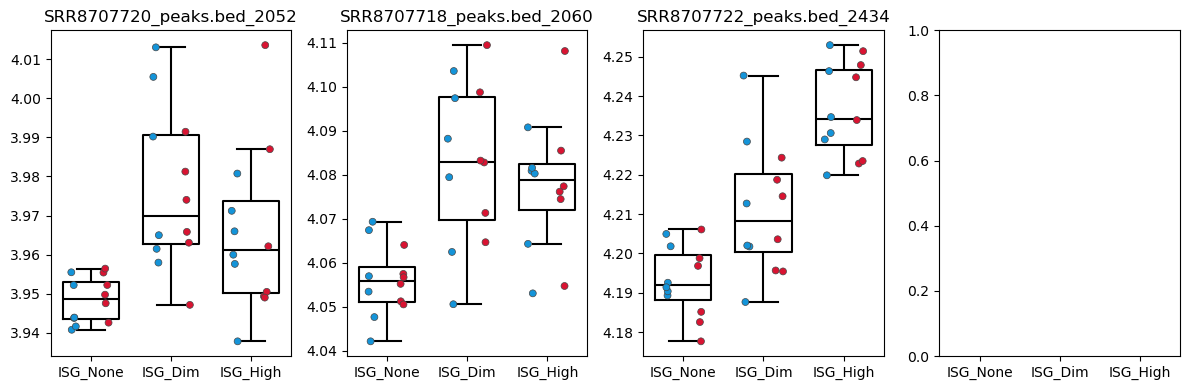

In [171]:
fig, axes = plt.subplots(1,4,figsize = [12,4], sharex=True)

axs = axes.ravel()

desired_order = ["ISG_None", "ISG_Dim", "ISG_High"]
df["cols"] = pd.Categorical(df["cols"], categories=desired_order, ordered=True)

co_ax = 0
for i in df.columns[:-4]:


    sns.boxplot(data=df, 
                    x='cols', 
                    y=i, 
                    fill=False, 
                    color='k', 
                    # hue='vac',
                    saturation=1,
                    ax=axs[co_ax],
                    showfliers=False, 
                    dodge=False, 
                    width=0.7
                    )
    
    strip = sns.stripplot(
              data=df,
              x='cols', 
              y=i,
              jitter=True, 
              palette=color_scheme[1:],
              dodge=True, 
              linewidth=0.5,
              ax=axs[co_ax],
              size=5, 
              legend=False, 
              hue='vac', 
             )

    axs[co_ax].set_title(i)
    axs[co_ax].set_ylabel('')
    axs[co_ax].set_xlabel('')
    co_ax += 1
    
plt.tight_layout()

# plt.savefig('../figure/Monocyte_CD14/ISGF3_expression.eps')

# Combine Motif Analysis-KDE - Figure S4

In [178]:
min_pct=dict()
for i in data1.obs['new_isg_subset'].unique():
    if 'Inflamm.' not in i and 'None' not in i:
        adata_group = data1[data1.obs["new_isg_subset"] == i].to_df()
        non_zero_counts_row = (adata_group != 0).sum(axis=0) / adata_group.shape[0]
        min_pct[i] = non_zero_counts_row

In [179]:
peak_df = pd.DataFrame.from_dict(min_pct)
pass_peaks = pd.DataFrame.from_dict(min_pct)[(pd.DataFrame.from_dict(min_pct) >=
                                              0.01).any(axis=1)].index

In [180]:
raw_count_r = snap.tl.aggregate_X(data1, groupby='new_isg_subset', normalize=None).to_df()
raw_count_r = raw_count_r.loc[[i for i in raw_count_r.index if 'J&J' not in i and 'Inflamm.' not in i],:]
raw_count_r = raw_count_r.loc[:,[i for i in raw_count_r.columns if i in pass_peaks]]
raw_count_r.T.to_csv('peak_matrix.tsv', sep='\t') # Save it for pySNAIL normalization

In [189]:
# Read normalized Read count from pySNAIL
norm_data_visit_sq = pd.read_csv('normalized_reads.tsv', sep='\t', index_col=0)
norm_data_visit_sq = norm_data_visit_sq.loc[[i for i in norm_data_visit_sq.index if i in pass_peaks],:]

In [218]:
# Use different combination for KDE, etc.
motif_list_chip_comb=['SRR8707718_peaks.bed','SRR8707720_peaks.bed', 'SRR8707722_peaks.bed']

In [195]:
df_ = pd.DataFrame(data1.var_names)
df_['Chromosome'] = df_[0].str.split(':',expand=True)[0]
df_['Start'] = df_[0].str.split(':',expand=True)[1].str.split('-',expand=True)[0]
df_['End'] = df_[0].str.split(':',expand=True)[1].str.split('-',expand=True)[1]
pr_df = pr.PyRanges(df_)
motifs_elements=dict()
columns=[]
for i in motif_list_chip_comb:
    motif_file = pd.read_csv(Chip_Motif + i,
                             sep='\t', 
                             skiprows=1,
                             header=None
                             )

    
    print([i,len(motif_file)])

    motif_file = motif_file.rename(columns={0:'Chromosome',1:'Start',2:'End',3:'Name',4:'Score',5:'Blank',6:'CL5',7:'C6',8:'Color'})
    motif_file_pr = pr.PyRanges(motif_file)
    motif_file_pr = motif_file_pr.extend(100)

    overlaps = pr_df.intersect(motif_file_pr)
    motifs_elements[i] = overlaps
    columns.append(set(overlaps.df[0].values))


['SRR8707718_peaks.bed', 132986]
['SRR8707720_peaks.bed', 170739]
['SRR8707722_peaks.bed', 116690]


In [197]:
from functools import reduce
common_elements = reduce(set.intersection, columns)

In [198]:
len(set(common_elements))

43

In [214]:
res_trial = norm_data_visit_sq.loc[[i for i in norm_data_visit_sq.index if i in common_elements],:]

In [215]:
res_trial.iloc[:, :2] = np.log2(res_trial.iloc[:, :2].div(res_trial['ISG_None'], axis=0))
res_trial_melted = res_trial.iloc[:, :2].melt(var_name="Condition", value_name="Value")

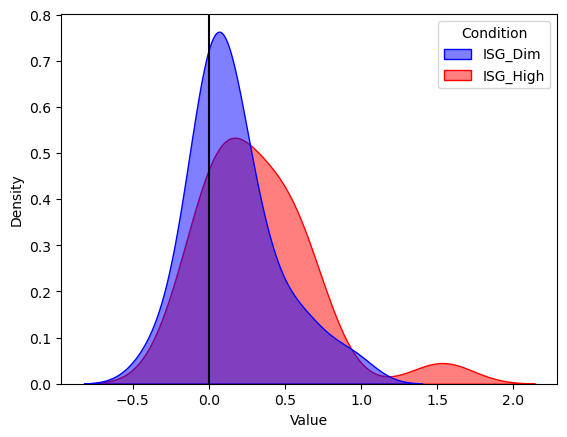

In [216]:
sns.kdeplot(data=res_trial_melted, x="Value", 
            hue="Condition", fill=True, 
            common_norm=True, alpha=0.5,
            palette=['b','r'])
plt.axvline(0, color='k')

# Z-score Figure-4

In [219]:
# Between ISG Subset
raw_count_r = snap.tl.aggregate_X(data1, groupby='isg_sub_vac_donor', normalize=None).to_df()
raw_count_r = raw_count_r.loc[[i for i in raw_count_r.index if 'J&J' not in i and 'Inflamm.' not in i],:]
raw_count_r = raw_count_r.loc[:,[i for i in raw_count_r.columns if i in pass_peaks]]
raw_count_r.T.to_csv('peak_matrix.tsv', sep='\t') # Save it for pySNAIL normalization

In [221]:
# Read normalized Read count from pySNAIL
norm_data_visit_sq = pd.read_csv('normalized_reads.tsv', sep='\t', index_col=0)
norm_data_visit_sq = norm_data_visit_sq.loc[[i for i in norm_data_visit_sq.index if i in pass_peaks],:]

In [226]:
# Use different combination for KDE, etc.
motif_list_chip_comb=['SRR8707718_peaks.bed','SRR8707720_peaks.bed', 'SRR8707722_peaks.bed']

In [227]:
df_ = pd.DataFrame(data1.var_names)
df_['Chromosome'] = df_[0].str.split(':',expand=True)[0]
df_['Start'] = df_[0].str.split(':',expand=True)[1].str.split('-',expand=True)[0]
df_['End'] = df_[0].str.split(':',expand=True)[1].str.split('-',expand=True)[1]
pr_df = pr.PyRanges(df_)
motifs_elements=dict()
columns=[]
for i in motif_list_chip_comb:
    motif_file = pd.read_csv(Chip_Motif + i,
                             sep='\t', 
                             skiprows=1,
                             header=None
                             )

    
    print([i,len(motif_file)])

    motif_file = motif_file.rename(columns={0:'Chromosome',1:'Start',2:'End',3:'Name',4:'Score',5:'Blank',6:'CL5',7:'C6',8:'Color'})
    motif_file_pr = pr.PyRanges(motif_file)
    motif_file_pr = motif_file_pr.extend(100)

    overlaps = pr_df.intersect(motif_file_pr)
    motifs_elements[i] = overlaps
    columns.append(set(overlaps.df[0].values))


['SRR8707718_peaks.bed', 132986]
['SRR8707720_peaks.bed', 170739]
['SRR8707722_peaks.bed', 116690]


In [228]:
from functools import reduce
common_elements = reduce(set.intersection, columns)

In [239]:
# Load the rna-seq data or subset of interest
# rna_data = sc.read_h5ad("scrna-seq.h5ad")
    
rna_data = sc.read_h5ad('myeloid.h5ad')

In [240]:
rna_data.obs = rna_data.obs.copy()
rna_data.obs['Visit'] = rna_data.obs['Visit'].str.replace(' ','_')
rna_data.obs['Visit'] = rna_data.obs['Visit'].str.replace('Baseline_2', 'Vac2_Baseline')
rna_data.obs['Vaccine'] = rna_data.obs['Vaccine'].astype(str)
rna_data.obs['person_visit'] = rna_data.obs['person'].astype(str) + '-' + rna_data.obs['Visit'].astype(str)
rna_data.obs['vaccine_person'] = rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['person'].astype(str)
rna_data = rna_data[~( (rna_data.obs['Vaccine'] != "J&J") & (rna_data.obs['Visit'].isin(["Vac1_D7"])) )]
rna_data = rna_data[~( (rna_data.obs['Vaccine'] == "J&J") & (rna_data.obs['Visit'].isin(["Vac2_D7"])) )]
rna_data = rna_data[~(rna_data.obs['Visit'].isin(["Day70","Day180"])),:]
rna_data.obs['vaccine_visit'] = rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)
rna_data.obs['vaccine_person_visit'] = rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['person'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)

/tmp/ipykernel_1225379/2833221543.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_data.obs['vaccine_visit'] = rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)


In [241]:
rna_data = rna_data[rna_data.obs['celltypes'] == 'Monocyte CD14',:]
rna_data = rna_data[rna_data.obs['new_subset_annotations_2'] != 'Monocyte CD14 ISG Inflamm.',:]
rna_data = rna_data[rna_data.obs['Vaccine'] != 'J&J',:]

In [243]:
rna_data.obs = rna_data.obs.copy()
rna_data.obs['new_subset_annotations_2'] = rna_data.obs['new_subset_annotations_2'].replace(
    'Monocyte CD14 ISG High','ISG_High')
rna_data.obs['new_subset_annotations_2'] = rna_data.obs['new_subset_annotations_2'].replace(
    'Monocyte CD14 ISG Dim','ISG_Dim')
rna_data.obs['new_subset_annotations_2'] = rna_data.obs['new_subset_annotations_2'].replace(
    'Monocyte CD14','ISG_None')
rna_data.obs['new_subset_annotations_2'] = rna_data.obs['new_subset_annotations_2'].str.replace(' ','_')

In [246]:
rna_data.obs['isg_sub_donor'] = rna_data.obs['new_subset_annotations_2'].astype(str) + '_' + rna_data.obs['person'].astype(str)
rna_data.obs['isg_sub_vac'] = rna_data.obs['new_subset_annotations_2'].astype(str) + '_' +rna_data.obs['Vaccine'].astype(str)
rna_data.obs['isg_sub_vac_donor'] = rna_data.obs['new_subset_annotations_2'].astype(str) + '_' + \
    rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['person'].astype(str)
rna_data.obs['vaccine_visit'] =  rna_data.obs['Vaccine'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)
rna_data.obs['isg_vac_donor_visit'] = rna_data.obs['isg_sub_vac_donor'].astype(str) + '_' + rna_data.obs['Visit'].astype(str)

In [250]:
[i for i in score_mat_v2_protein['Gene Name'].unique() if i not in rna_data.raw.var_names]

['RIGI']

In [251]:
rna_genes = score_mat_v2_protein['Gene Name'].unique()
rna_genes[rna_genes == 'RIGI'] =  'DDX58'

In [254]:
rna_genes = [i for i in rna_genes if i in rna_data.raw.var_names]

In [255]:
genedf = sc.get.obs_df(rna_data, keys=["isg_vac_donor_visit", *rna_genes], use_raw=True)
dfm_rna = genedf.groupby("isg_vac_donor_visit", observed=True).mean().T

In [256]:
dfm_rna_zscore = scipy.stats.zscore(dfm_rna, axis=1)

In [257]:
score_mat_v2 = dfm_rna_zscore
group = ['ISG_None', 'ISG_Dim', 'ISG_High']
vaccine = ['Moderna', 'Pfizer']
p_val=dict()
log2_diff=dict()
agg_dict=dict()
baseline = score_mat_v2.loc[:,[i for i in score_mat_v2.columns if group[0] in i]]
for group_in in group:
    test_group = score_mat_v2.loc[:,[i for i in score_mat_v2.columns if group_in in i]]
    agg_dict[group_in] = test_group.mean(axis=1)

score_mat_agg = pd.DataFrame.from_dict(agg_dict)
score_mat_agg.index = score_mat_v2.index

In [259]:
df_melted = pd.melt(score_mat_agg.reset_index(), id_vars=["index"])

/tmp/ipykernel_1225379/1592296568.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  swarm = sns.swarmplot(x='variable', y='value', data=df_melted,
/tmp/ipykernel_1225379/1592296568.py:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  swarm = sns.swarmplot(x='variable', y='value', data=df_melted,
/tmp/ipykernel_1225379/1592296568.py:24: UserWarning: 
The palette list has fewer values (6) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x='x', y='y', data=combine_off, hue='sub', legend=False, palette=['k'] * 6, #


<Axes: xlabel='variable', ylabel='value'>

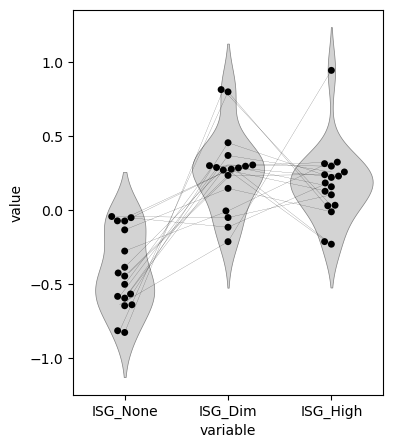

In [262]:
plt.figure(figsize=(4, 5))


df_melted.sort_values(['variable','value'], inplace=True)
desired_order = ['ISG_None', 'ISG_Dim', 'ISG_High']
# desired_order = ['Baseline 1', 'Vac1 D1', 'Baseline 2', 'Vac2 D1', 'Vac2 D7']
df_melted["variable"] = pd.Categorical(df_melted["variable"], categories=desired_order, ordered=True)

swarm = sns.swarmplot(x='variable', y='value', data=df_melted, 
           legend=True, #marker=mark, 
           palette=['k'], dodge=False
         )

combine_off = []
collections = swarm.collections
for col in collections:
    offsets = col.get_offsets()
    plot_data = pd.DataFrame(offsets, columns=['x', 'y'])
    plot_data = plot_data.sort_values('y')
    combine_off.append(plot_data)
combine_off = pd.concat(combine_off).reset_index(drop=True)
combine_off['sub'] = df_melted['index'].values

sns.lineplot(x='x', y='y', data=combine_off, hue='sub', legend=False, palette=['k'] * 6, #
             markers=False, linewidth=0.1)

sns.violinplot(data=df_melted, x="variable", y="value", 
               inner=None, color="lightgray", linewidth=0.5)

# HEATMAP - Figure S4

In [380]:
genedf = sc.get.obs_df(rna_data, keys=["isg_vac_donor_visit", *rna_genes], use_raw=True)
dfm_rna = genedf.groupby("isg_vac_donor_visit", observed=True).mean().T

In [381]:
score_mat_v2_zscore = scipy.stats.zscore(dfm_rna, axis=1)

In [382]:
score_mat_v2_temp = score_mat_v2_zscore
group = ['ISG_None', 'ISG_Dim', 'ISG_High']
vaccine = ['Moderna', 'Pfizer']
p_val=dict()
log2_diff=dict()
agg_dict=dict()
baseline = score_mat_v2_temp.loc[:,[i for i in score_mat_v2_temp.columns if group[0] in i]]
for group_in in group:
    test_group = score_mat_v2_temp.loc[:,[i for i in score_mat_v2_temp.columns if group_in in i]]

    agg_dict[group_in] = test_group.mean(axis=1)

score_mat_agg = pd.DataFrame.from_dict(agg_dict)
score_mat_agg.index = score_mat_v2['Gene Name']


In [383]:
score_mat_agg['dim-high'] = score_mat_agg['ISG_Dim'] * 5 + score_mat_agg['ISG_High'] - score_mat_agg['ISG_None']

In [384]:
score_mat_agg.sort_values('dim-high', ascending=False, inplace=True)

In [385]:
print(score_mat_agg.iloc[:,:3].max().max(),score_mat_agg.iloc[:,:3].min().min())

0.9430017 -0.82604927


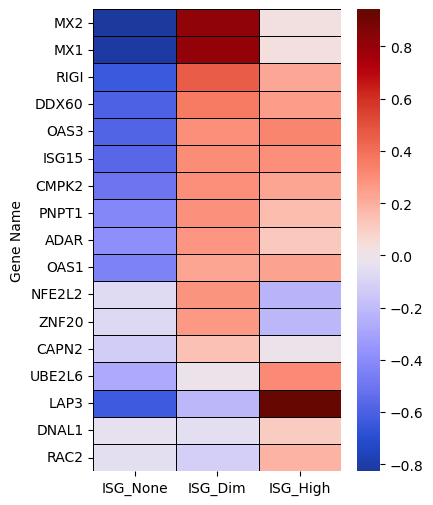

In [387]:
plt.figure(figsize=(4, 6))
clus = sns.heatmap(
                score_mat_agg.iloc[:,:3],
                center=0,
                cmap=cc.CET_D1A,
                linewidths=0.5,
                linecolor="black",
      )


In [389]:
raw_count_r = snap.tl.aggregate_X(data1, groupby='isg_sub_vac', normalize=None).to_df()
raw_count_r = raw_count_r.loc[[i for i in raw_count_r.index if 'J&J' not in i and 'Inflamm.' not in i],:]
raw_count_r = raw_count_r.loc[:,[i for i in raw_count_r.columns if i in pass_peaks]]
raw_count_r.T.to_csv('peak_matrix.tsv', sep='\t') # Save it for pySNAIL normalization

In [391]:
# Read normalized Read count from pySNAIL
norm_data_visit_sq = pd.read_csv('normalized_reads.tsv', sep='\t', index_col=0)
norm_data_visit_sq = norm_data_visit_sq.loc[[i for i in norm_data_visit_sq.index if i in pass_peaks],:]

In [392]:
norm_data_visit = norm_data_visit_sq.loc[[i for i in norm_data_visit_sq.index if i in common_elements],:]
score_mat_v2 = np.log2(norm_data_visit+1)
score_mat_v2 = score_mat_v2.merge(all_peaks[['feature name','Gene Name','Annotation','Annotation2',
                'Gene Type']].set_index('feature name'), how='left', left_index=True, right_index=True)
score_mat_v2 = score_mat_v2[~(score_mat_v2['Annotation2'] == 'Trans')]
score_mat_v2 = score_mat_v2[(score_mat_v2['Gene Type'] == 'protein-coding')]

In [395]:
score_mat_v2_zscore = scipy.stats.zscore(score_mat_v2.iloc[:,:-4], axis=1)
# score_mat_v2_zscore = scipy.stats.zscore(dfm_rna, axis=1)

In [396]:
score_mat_v2_temp = score_mat_v2_zscore
group = ['ISG_None', 'ISG_Dim', 'ISG_High']
vaccine = ['Moderna', 'Pfizer']
p_val=dict()
log2_diff=dict()
agg_dict=dict()
baseline = score_mat_v2_temp.loc[:,[i for i in score_mat_v2_temp.columns if group[0] in i]]
for group_in in group:
    test_group = score_mat_v2_temp.loc[:,[i for i in score_mat_v2_temp.columns if group_in in i]]

    agg_dict[group_in] = test_group.mean(axis=1)

score_mat_agg = pd.DataFrame.from_dict(agg_dict)
score_mat_agg.index = score_mat_v2['Gene Name']


In [398]:
score_mat_agg['dim-high'] = score_mat_agg['ISG_Dim'] * 5 + score_mat_agg['ISG_High'] - score_mat_agg['ISG_None']

In [399]:
score_mat_agg.sort_values('dim-high', ascending=False, inplace=True)

In [400]:
print(score_mat_agg.iloc[:,:3].max().max(),score_mat_agg.iloc[:,:3].min().min())

1.329601862896956 -1.3597296119666065


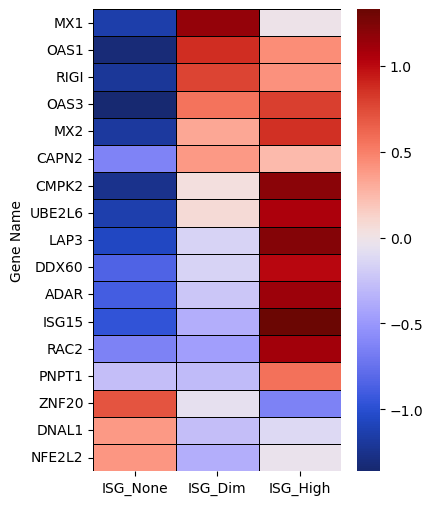

In [401]:
plt.figure(figsize=(4, 6))
clus = sns.heatmap(
                score_mat_agg.iloc[:,:3],
                center=0,
                cmap=cc.CET_D1A,
                linewidths=0.5,
                linecolor="black",
      )


# RNA-ATAC Correlation - Figure 4

In [422]:
gene_names_atac = 'MX1'

In [423]:
raw_count_r = snap.tl.aggregate_X(data1, groupby='new_isg_subset', normalize=None).to_df()
raw_count_r = raw_count_r.loc[[i for i in raw_count_r.index if 'J&J' not in i and 'Inflamm.' not in i],:]
raw_count_r = raw_count_r.loc[:,[i for i in raw_count_r.columns if i in pass_peaks]]
raw_count_r.T.to_csv('peak_matrix.tsv', sep='\t') # Save it for pySNAIL normalization

In [426]:
# Read normalized Read count from pySNAIL
norm_data_visit_sq = pd.read_csv('normalized_reads.tsv', sep='\t', index_col=0)
norm_data_visit_sq = norm_data_visit_sq.loc[[i for i in norm_data_visit_sq.index if i in pass_peaks],:]

In [427]:
norm_data_visit = norm_data_visit_sq.loc[[i for i in norm_data_visit_sq.index if i in common_elements],:]
score_mat_v2 = np.log2(norm_data_visit+1)
score_mat_v2 = score_mat_v2.merge(all_peaks[['feature name','Gene Name','Annotation','Annotation2',
                'Gene Type']].set_index('feature name'), how='left', left_index=True, right_index=True)
score_mat_v2_protein = score_mat_v2
score_mat_v2_protein = score_mat_v2_protein[score_mat_v2_protein['Gene Type'] == 'protein-coding']

In [428]:
df_atac = score_mat_v2_protein[score_mat_v2_protein['Gene Name'] == gene_names_atac].iloc[:,:-4].T

In [429]:
gene_names_rna = ['MX1']

In [430]:
genedf = sc.get.obs_df(
    rna_data,
    keys=["isg_sub_vac_donor", *gene_names_rna],
    use_raw=True
    )

rna_mean = genedf.groupby("isg_sub_vac_donor").mean()
rna_mean = rna_mean.rename(columns={rna_mean.columns[0]:'rna'})
rna_mean = rna_mean.loc[[i for i in rna_mean.index if 'Inflamm.' not in i],:]

In [431]:
rna_mean.index == df_atac.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [432]:
final_cor = pd.concat([df_atac, rna_mean], axis=1)
final_cor = final_cor.rename(columns={final_cor.columns[0]:'atac'})

In [433]:
final_cor['cols'] = pd.DataFrame(final_cor.index)[0].str.rsplit('_',expand=True, n=2)[0].values
final_cor['vac'] = pd.DataFrame(final_cor.index)[0].str.rsplit('_',expand=True, n=2)[1].values
final_cor['donor'] = pd.DataFrame(final_cor.index)[0].str.rsplit('_',expand=True, n=1)[1].values

Text(0.05, 0.9, 'p-value: 2.24e-03')

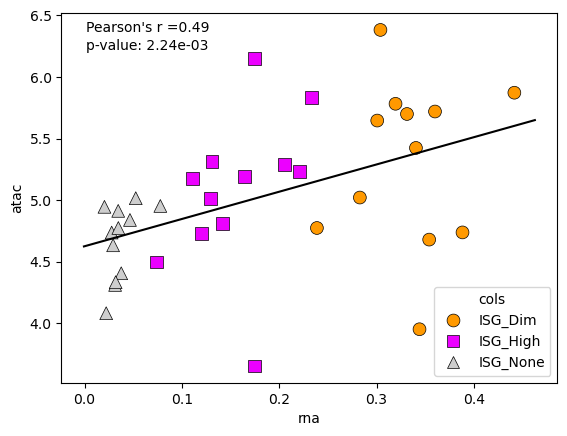

In [434]:
sns.scatterplot(x='rna', y='atac', data=final_cor, hue='cols' , legend=True, 
             palette=['#FF9900','#EC00FF','#CECECE'],
             markers=['o','s','^'],
             edgecolor='black',
             linewidth=0.5,
             style='cols',
             s=85,
             )

r, p = scipy.stats.spearmanr(final_cor['atac'], final_cor['rna'])
ax = plt.gca() # Get a matplotlib's axes instance

import numpy as np
m, b = np.polyfit(final_cor['rna'], final_cor['atac'], 1)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-k')


plt.text(.05, .95, "Pearson's r ={:.2f}".format(r), transform=ax.transAxes)
plt.text(.05, .9, f'p-value: {p:.2e}', transform=ax.transAxes)